In [14]:
#Required imports

#Import and handling data 
import miepython
import os
from os.path import isfile, join
import importlib
import pandas as pd
from importlib_resources import files

#Data treatment and mathematics
import numpy as np
from scipy.optimize import curve_fit

#Data visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rc,rcParams

from module import *

In [15]:
#Default parameters for data visualization
rcParams['figure.figsize'] = [8,6]
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 12
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 16
rcParams['ytick.major.width'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 2
rcParams['lines.markersize'] = 10
rcParams['axes.titlesize'] = 25
rcParams['axes.labelsize'] = 25
rcParams['legend.fontsize'] = 18
rcParams['legend.frameon'] = False
rc('text', usetex = 'False')
rc('font', family = 'serif')

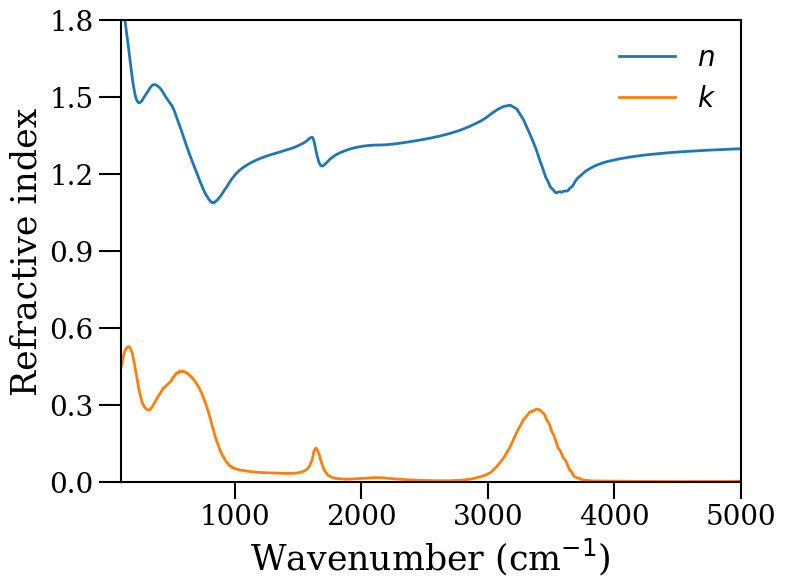

In [16]:
#First, we will import H2O refractive index data from Segelstein et al. 1981 by using the function obtain_reference_data():

# Load data
h2o_cm, h2o_n_re, h2o_n_im = obtain_reference_data()

# Create plot
fig, ax = plt.subplots()
ax.plot(h2o_cm, h2o_n_re, label=r'$n$', color='tab:blue')
ax.plot(h2o_cm, h2o_n_im, label=r'$k$', color='tab:orange')

# Axis limits and labels
ax.set_xlim(100, 5000)
ax.set_ylim(0, 1.8)
ax.set_yticks([0,0.3,0.6,0.9,1.2,1.5,1.8])
ax.set_xlabel('Wavenumber (cm$^{-1}$)')
ax.set_ylabel('Refractive index')

# Legend instead of manual annotate
ax.legend(fontsize=20, loc='upper right')


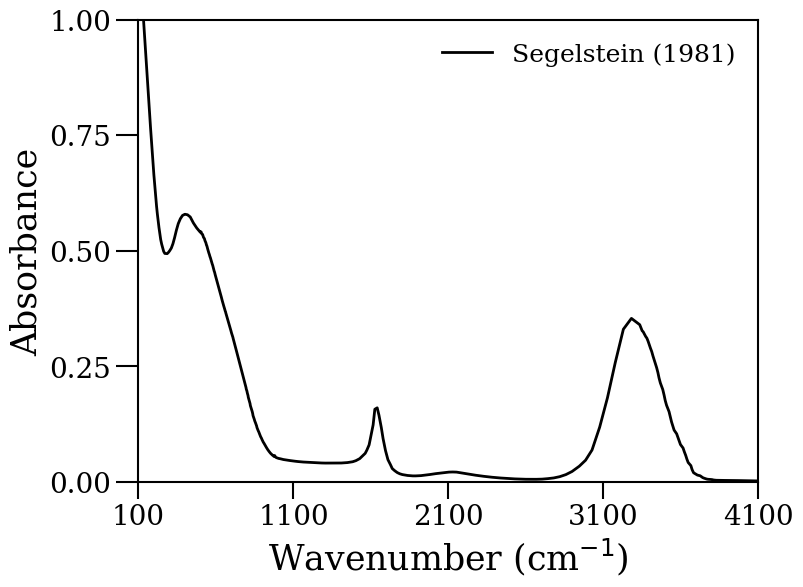

In [17]:
# Plot the absorbance computed from Segelstein et al. (1981)

# Parameters
f = 0.5 
n_IRE = 2.4
theta = 45  # degrees

# Load data and compute absorbance
wavenumbers, _, _ = obtain_reference_data()
absorbance = compute_A(wavenumbers, f, n_IRE, theta)

# Create plot
plt.figure()
plt.plot(wavenumbers, absorbance, color="black", linestyle='-', linewidth=2, label='Segelstein (1981)')

# Axis formatting
plt.xlim(100, 4100)
plt.ylim(0, 1)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Absorbance')

# Ticks
plt.xticks(np.arange(100, 5001, 1000))
plt.yticks(np.linspace(0, 1, 5))

# Optional: legend and grid
plt.legend()

0.0014840328017827295
f_s = 0.584 ± 0.001


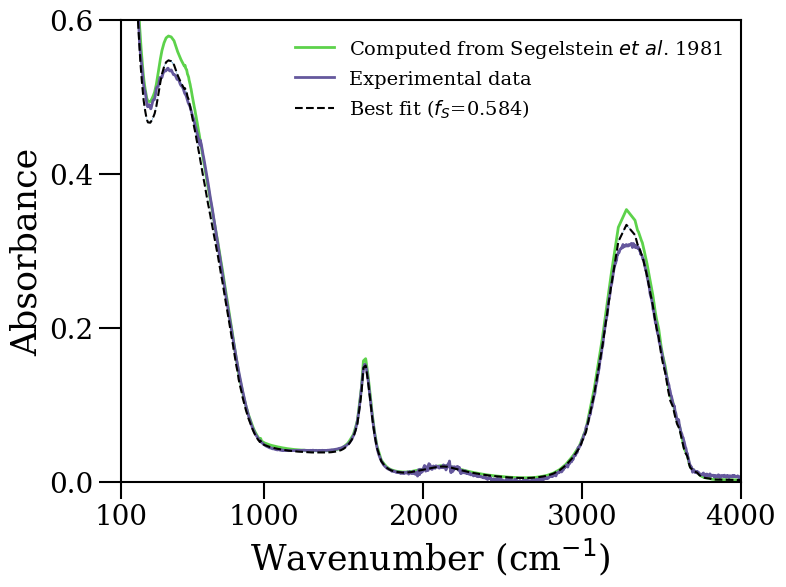

In [18]:
# Generate x-axis for interpolation
x = np.linspace(100, 4000, 3900)


# Interpolate Segelstein model to match x-axis
mod_y = np.interp(x, h2o_cm, absorbance)

# Read experimental data
experimental_data = pd.read_csv('ATR_absorbance_H2O.csv',delimiter=',')
experimental_absorbance = experimental_data['absorbance']
experimental_x = experimental_data['wavenumber(cm-1)']

# Interpolate experimental data to match x axis
mod_exp_y = np.interp(x, experimental_x, experimental_absorbance)

# Fit polarization fraction f
popt, pcov = curve_fit(compute_A, x, mod_exp_y, p0=0.5)
f_fit = popt[0]
f_err = np.sqrt(np.diag(pcov))[0]
print(f_err)
print(f"f_s = {f_fit:.3f} ± {f_err:.3f}")

# Plotting
plt.figure()

plt.plot(x, compute_A(x, 0.5), c='#5DD24B', ls='-', lw=2, label=r'Computed from Segelstein $et$ $al$. 1981')
plt.plot(x, mod_exp_y, c='#65589D', lw=2, label='Experimental data')
plt.plot(x, compute_A(x, f_fit), c='black', lw=1.5, ls='--', label=fr'Best fit ($f_S$={f_fit:.3f})')
plt.fill_between(x, compute_A(x, f_fit-0.002), compute_A(x, f_fit+0.002))
# Plot styling
plt.xlim(100, 4000)
plt.ylim(0, 0.6)
plt.xticks([100, 1000, 2000, 3000, 4000])
plt.yticks([0, 0.2, 0.4, 0.6])
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Absorbance')
plt.legend(frameon=False, fontsize=14)
plt.savefig("Figure1.pdf", format="pdf", bbox_inches="tight")


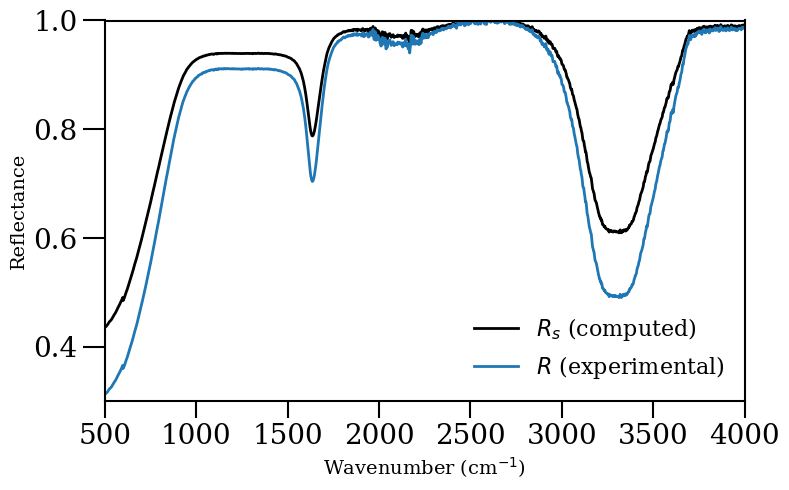

In [19]:
# Compute polarization angle in radians and degrees
phi_rad = get_pol_angle(f)
phi_deg = np.degrees(phi_rad)

# Compute s-polarized reflectance
R_exp = A_to_R(mod_exp_y)
R_S = R_S_45(phi_rad, R_exp)

# Plot experimental and computed reflectance
plt.figure(figsize=(8, 5))  # optional: define figure size for consistency

plt.plot(x, R_S, color='black', linewidth=2, label=r'$R_s$ (computed)')
plt.plot(x, R_exp, color='C0', linewidth=2, label='$R$ (experimental)')

# Axes formatting
plt.xlim(500, 4000)
plt.ylim(0.3, 1.0)
plt.xticks(np.arange(500, 4500, 500))
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)

# Legend and layout
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()

In [21]:
n_inf = 1.315
even_indices = np.arange(0, len(x), 2)
x_even = x[even_indices]
R_S_even = np.array(R_S)[even_indices]

# Create S input range
S_input = [0,666,800]
results = {}

# Loop over each S value
for S in S_input:
    # Compute phi values only for even indices
    phi_values = [phi_x(xi, x, R_S, n_inf=n_inf, S=S, n_IRE=n_IRE) for xi in x_even]
    phi_values = np.interp(x, x_even, phi_values )
    # Compute n_sample using corresponding reflectance and phi
    n_sample = compute_n_sample(phi_values, R_S,n_IRE)
    
    results[S] = n_sample



Text(0, 0.5, '$k$')

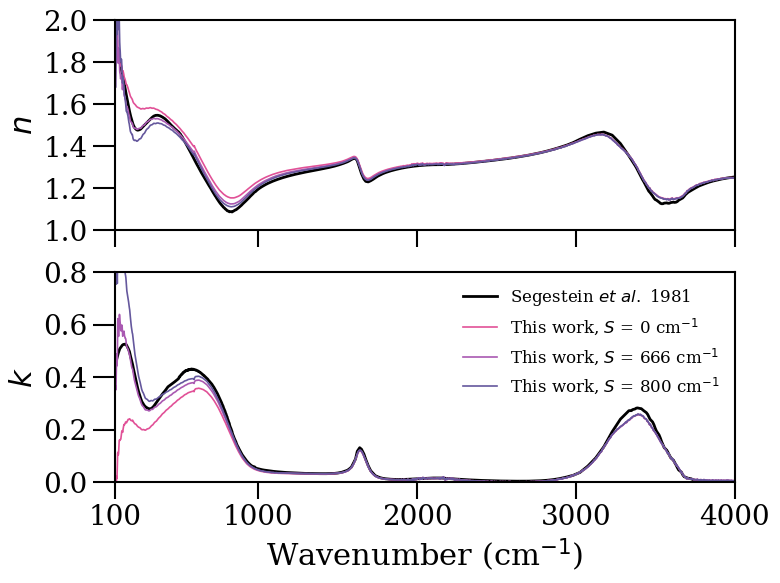

In [22]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

# Plot literature data
ax1.plot(h2o_cm, h2o_n_re, lw=2, ls='-', c='black')
ax2.plot(h2o_cm, h2o_n_im, lw=2, ls='-', c='black', label="Segestein $et$ $al.$ 1981")

# Plot computed data
ax1.plot(x,results[0].real,c='#E15197',lw=1.2 )
ax2.plot(x,results[0].imag,c='#E15197',lw=1.2,label ="This work, $S$ = 0 cm$^{-1}$")

ax1.plot(x,results[666].real,c='#A959B1',lw=1.2 )
ax2.plot(x,results[666].imag,c='#A959B1',lw=1.2,label ="This work, $S$ = 666 cm$^{-1}$")

ax1.plot(x,results[800].real,c='#65589D',lw=1.2 )
ax2.plot(x,results[800].imag,c='#65589D',lw=1.2,label ="This work, $S$ = 800 cm$^{-1}$")

# Legend
ax2.legend(fontsize=12, frameon=False, ncols=1)

# Axis limits and ticks
ax1.set_ylim(1, 2)
ax1.set_yticks([1, 1.2, 1.4, 1.6, 1.8, 2])

ax2.set_ylim(0, 0.8)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

ax2.set_xlim(100, 4000)
ax2.set_xticks([100, 1000, 2000, 3000, 4000])

# Labels
ax2.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=22)
ax1.set_ylabel('$n$', fontsize=22)
ax2.set_ylabel('$k$', fontsize=22)
